# Parameter Similarity

In [1]:
import numpy as np
import torch
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sys

sys.path.append('../')
from sample_batch_data import prepare_data

sys.path.append('../../')
from decision_transformer.models.decision_transformer import DecisionTransformer

In [2]:
sns.set_style("ticks")
sns.set_context("paper", 1.5, {"lines.linewidth": 2})

## Compute and Save L2 Distance and Cosine Similarity of Parameters

In [8]:
seed=666
epoch1=0
epoch2=40
env_name='hopper'
reward_state_action='state'

model_names = ['gpt2', 'igpt', 'dt']

for model_name in model_names:
    
    torch.manual_seed(seed)

    dataset_name = 'medium'

    if model_name == 'gpt2':
        pretrained_lm1 = 'gpt2'
    elif model_name == 'clip':
        pretrained_lm1 = 'openai/clip-vit-base-patch32'
    elif model_name == 'igpt':
        pretrained_lm1 = 'openai/imagegpt-small'
    elif model_name == 'dt':
        pretrained_lm1 = False

    variant = {
        'embed_dim': 768,
        'n_layer': 12,
        'n_head': 1,
        'activation_function': 'relu',
        'dropout': 0.2, # 0.1
        'load_checkpoint': False if epoch1==0 else f'../../checkpoints/{model_name}_medium_{env_name}_666/model_{epoch1}.pt',
        'seed': seed,
        'outdir': f"checkpoints/{model_name}_{dataset_name}_{env_name}_{seed}",
        'env': env_name,
        'dataset': dataset_name,
        'model_type': 'dt',
        'K': 20, # 2
        'pct_traj': 1.0,
        'batch_size': 100,  # 64
        'num_eval_episodes': 100,
        'max_iters': 40,
        'num_steps_per_iter': 2500,
        'pretrained_lm': pretrained_lm1,
        'gpt_kmeans': None,
        'kmeans_cache': None,
        'frozen': False,
        'extend_positions': False,
        'share_input_output_proj': True
    }

    os.makedirs(variant["outdir"], exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    trajectories, sorted_inds, state_dim, act_dim, max_ep_len, state_mean, state_std, num_trajectories, p_sample, scale = prepare_data(variant)

    K = variant["K"]

    model1 = DecisionTransformer(
        args=variant,
        state_dim=state_dim,
        act_dim=act_dim,
        max_length=K,
        max_ep_len=max_ep_len,
        hidden_size=variant["embed_dim"],
        n_layer=variant["n_layer"],
        n_head=variant["n_head"],
        n_inner=4 * variant["embed_dim"],
        activation_function=variant["activation_function"],
        n_positions=1024,
        resid_pdrop=variant["dropout"],
        attn_pdrop=0.1,
    )
    if variant["load_checkpoint"]:
        state_dict = torch.load(variant["load_checkpoint"], map_location=torch.device('cpu'))
        model1.load_state_dict(state_dict)
        print(f"Loaded from {variant['load_checkpoint']}")

        model1.eval()

    variant['load_checkpoint'] = checkpoint2 = False if epoch2==0 else f'../../checkpoints/{model_name}_medium_{env_name}_666/model_{epoch2}.pt'
    model2 = DecisionTransformer(
        args=variant,
        state_dim=state_dim,
        act_dim=act_dim,
        max_length=K,
        max_ep_len=max_ep_len,
        hidden_size=variant["embed_dim"],
        n_layer=variant["n_layer"],
        n_head=variant["n_head"],
        n_inner=4 * variant["embed_dim"],
        activation_function=variant["activation_function"],
        n_positions=1024,
        resid_pdrop=variant["dropout"],
        attn_pdrop=0.1,
    )
    if variant["load_checkpoint"]:
        state_dict = torch.load(variant["load_checkpoint"], map_location=torch.device('cpu'))
        model2.load_state_dict(state_dict)
        print(f"Loaded from {variant['load_checkpoint']}")

        model2.eval()

    param_dist = {}
    param_cos = {}
    for (name1, param1), (name2, param2) in zip(model1.transformer.h.named_parameters(), model2.transformer.h.named_parameters()):
        param_dist[name1] = torch.linalg.norm(param2 - param1).detach().numpy()
        param_cos[name1] = (torch.dot(param1.view(-1), param2.view(-1)) / (torch.linalg.norm(param1) * torch.linalg.norm(param2) + 1e-6)).detach().numpy()

    np.save(f'results/paramdist_{epoch1}_{epoch2}_{model_name}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.npy', param_dist)
    np.save(f'results/paramcos_{epoch1}_{epoch2}_{model_name}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.npy', param_cos)

Starting new experiment: hopper medium
2186 trajectories, 999906 timesteps found
Average return: 1422.06, std: 378.95
Max return: 3222.36, min: 315.87
Loading from pretrained
Loading from pretrained
Loaded from ../../checkpoints/gpt2_medium_hopper_666/model_40.pt
Starting new experiment: hopper medium
2186 trajectories, 999906 timesteps found
Average return: 1422.06, std: 378.95
Max return: 3222.36, min: 315.87
Loading from pretrained


You are using a model of type imagegpt to instantiate a model of type gpt2. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at openai/imagegpt-small were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2Model were not initialized from the model checkpoint at openai/imagegpt-small and are newly initialized: ['transformer.h.5.ln_1.bias', 'transformer.h.10.ln_2.bias', 'transformer.h.8.ln_1.bias', 'transformer.h.6.ln_1.bias', 'transformer.h.6.ln_2.bias'

Loading from pretrained


You are using a model of type imagegpt to instantiate a model of type gpt2. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at openai/imagegpt-small were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2Model were not initialized from the model checkpoint at openai/imagegpt-small and are newly initialized: ['transformer.h.5.ln_1.bias', 'transformer.h.10.ln_2.bias', 'transformer.h.8.ln_1.bias', 'transformer.h.6.ln_1.bias', 'transformer.h.6.ln_2.bias'

Loaded from ../../checkpoints/igpt_medium_hopper_666/model_40.pt
Starting new experiment: hopper medium
2186 trajectories, 999906 timesteps found
Average return: 1422.06, std: 378.95
Max return: 3222.36, min: 315.87
Loaded from ../../checkpoints/dt_medium_hopper_666/model_40.pt


## Plot L2 Distance and Cosine Similarity

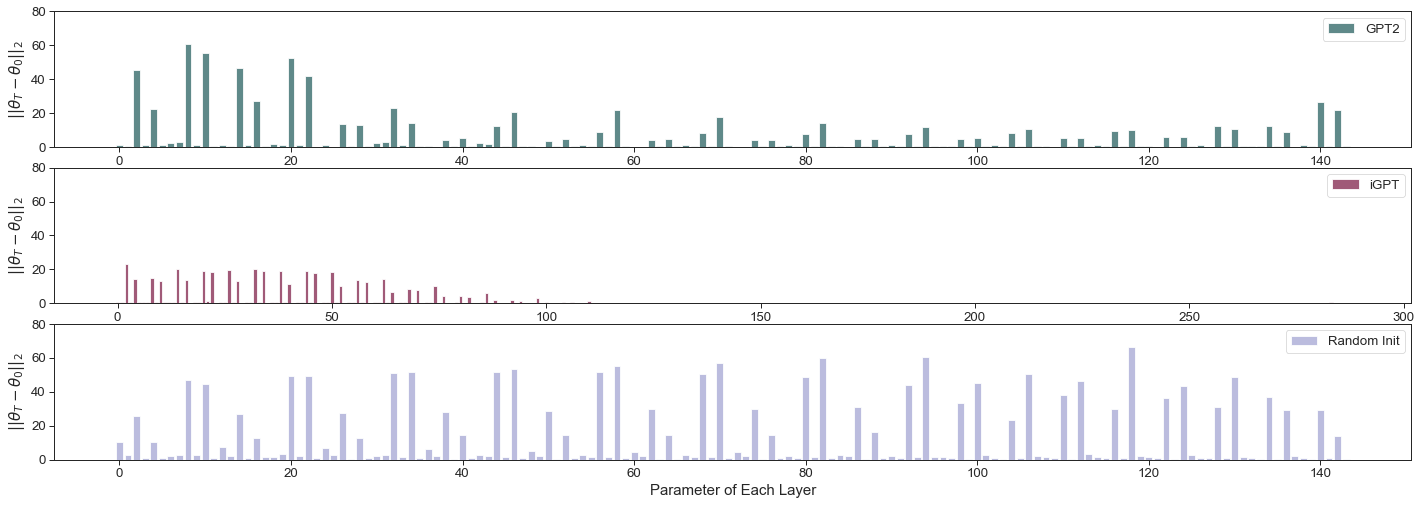

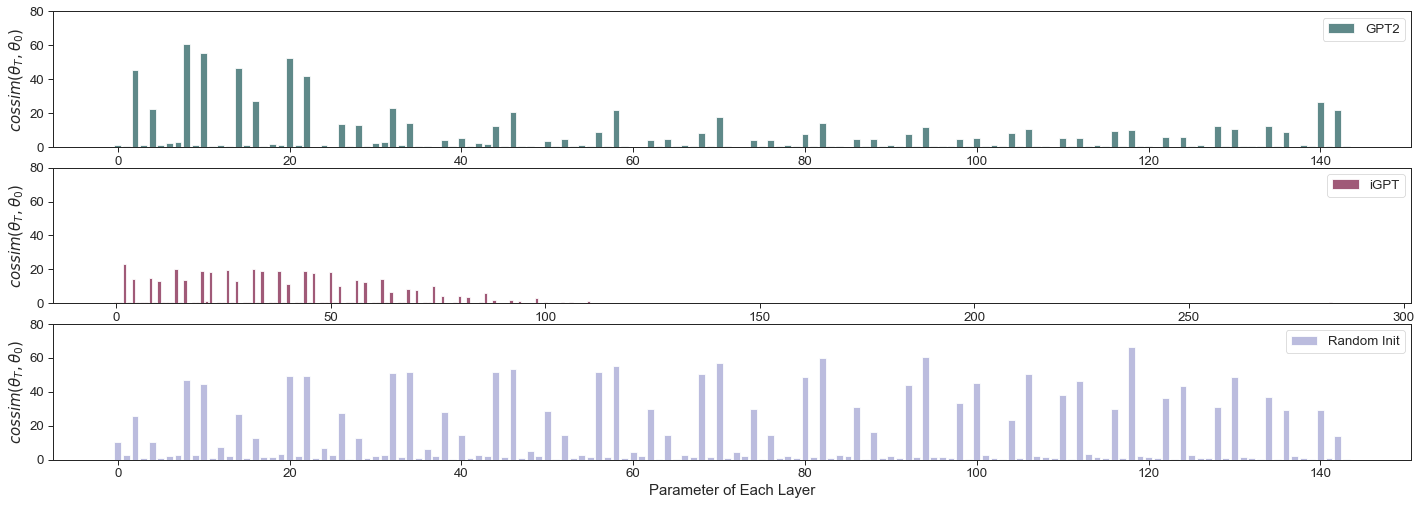

Labels of xticks: 
 ['0.ln_1.weight', '0.ln_1.bias', '0.attn.c_attn.weight', '0.attn.c_attn.bias', '0.attn.c_proj.weight', '0.attn.c_proj.bias', '0.ln_2.weight', '0.ln_2.bias', '0.mlp.c_fc.weight', '0.mlp.c_fc.bias', '0.mlp.c_proj.weight', '0.mlp.c_proj.bias', '1.ln_1.weight', '1.ln_1.bias', '1.attn.c_attn.weight', '1.attn.c_attn.bias', '1.attn.c_proj.weight', '1.attn.c_proj.bias', '1.ln_2.weight', '1.ln_2.bias', '1.mlp.c_fc.weight', '1.mlp.c_fc.bias', '1.mlp.c_proj.weight', '1.mlp.c_proj.bias', '2.ln_1.weight', '2.ln_1.bias', '2.attn.c_attn.weight', '2.attn.c_attn.bias', '2.attn.c_proj.weight', '2.attn.c_proj.bias', '2.ln_2.weight', '2.ln_2.bias', '2.mlp.c_fc.weight', '2.mlp.c_fc.bias', '2.mlp.c_proj.weight', '2.mlp.c_proj.bias', '3.ln_1.weight', '3.ln_1.bias', '3.attn.c_attn.weight', '3.attn.c_attn.bias', '3.attn.c_proj.weight', '3.attn.c_proj.bias', '3.ln_2.weight', '3.ln_2.bias', '3.mlp.c_fc.weight', '3.mlp.c_fc.bias', '3.mlp.c_proj.weight', '3.mlp.c_proj.bias', '4.ln_1.weight', '4

In [18]:
seed=666
epoch1=0
epoch2=40
env_name='hopper'
reward_state_action='state'
dataset_name = 'medium'

model_names = ['gpt2', 'igpt', 'dt']
sim_metrics_list = ['paramdist', 'paramcos']

param_sim_dicts = {
    sim_metrics: {
        model_name: np.load(f'results/paramdist_{epoch1}_{epoch2}_{model_name}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.npy', allow_pickle=True).item() for model_name in model_names
    } for sim_metrics in sim_metrics_list
}

colors = {'gpt2': (0.372, 0.537, 0.537), 'igpt': (0.627, 0.352, 0.470), 'dt': (0.733, 0.737, 0.870)}
labels = {'gpt2': 'GPT2', 'igpt': 'iGPT', 'dt': 'Random Init'}

for dist_of_cos, paramsim_dict in param_sim_dicts.items():
    if dist_of_cos == 'paramdist':
        fig_y_label = r'$||\theta_T - \theta_0||_2$'
    else:
        fig_y_label = r'$cossim(\theta_T, \theta_0)$'
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 7))
    fig.subplots_adjust(bottom=0.1)
    for i, ax in enumerate(axes):
        model_name = model_names[i]
        ax.bar(x=range(len(paramsim_dict[model_name])), height=list(paramsim_dict[model_name].values()), color=colors[model_name], label=labels[model_name])
        ax.set_ylim(0, 80)
        ax.set_ylabel(fig_y_label, fontsize=15)
        ax.legend(loc='upper right')
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.15)
    plt.xlabel('Parameter of Each Layer', fontsize=15)
    plt.savefig(f'figs/{dist_of_cos}_{epoch1}_{epoch2}_gpt2_igpt_dt_{env_name}_{dataset_name}_{seed}_{reward_state_action}.pdf')
    plt.show()
print(f'Labels of xticks: \n {list(paramsim_dict[model_name].keys())}')